In [164]:
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [165]:
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [166]:
train_data.isnull().mean()


ID           0.0
Promotion    0.0
purchase     0.0
V1           0.0
V2           0.0
V3           0.0
V4           0.0
V5           0.0
V6           0.0
V7           0.0
dtype: float64

In [167]:
test_data = pd.read_csv('./Test.csv')
test_data.head(7)

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2
5,13,Yes,0,0,32.566788,-1.684550,2,1,2,1
6,19,No,0,2,29.833921,-1.078506,1,2,3,2


In [168]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']


In [169]:
train_data['Promotion'].value_counts()


Yes    42364
No     42170
Name: Promotion, dtype: int64

In [170]:
train_data['purchase'].value_counts()


0    83494
1     1040
Name: purchase, dtype: int64

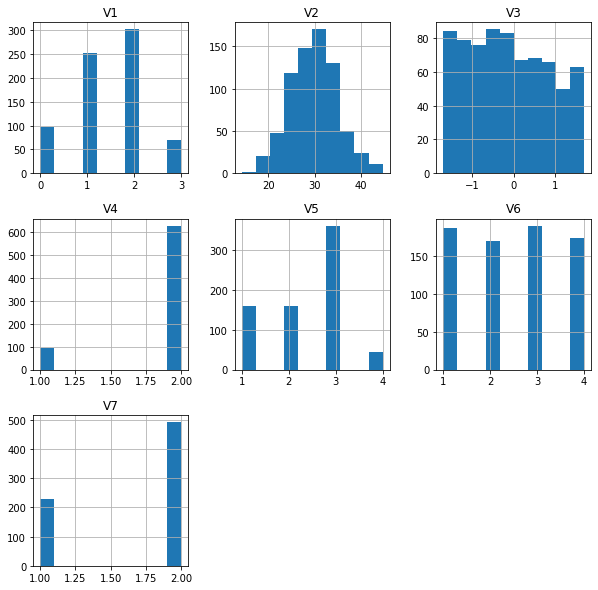

In [171]:
train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==1)][features].hist(figsize=(10,10));


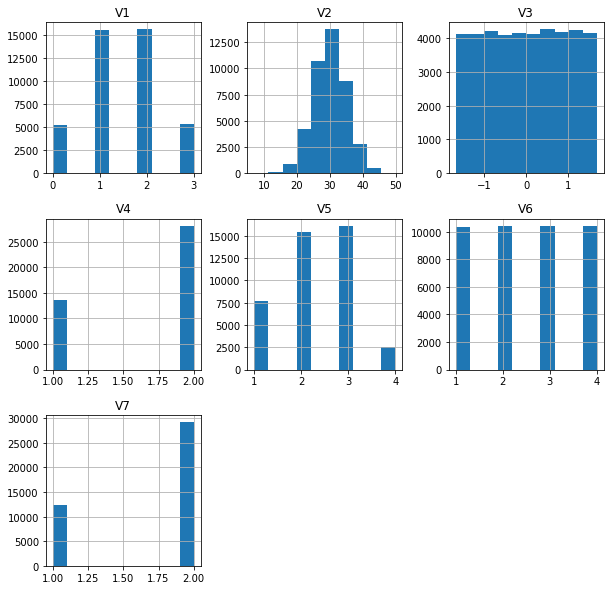

In [172]:
train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==0)][features].hist(figsize=(10,10));


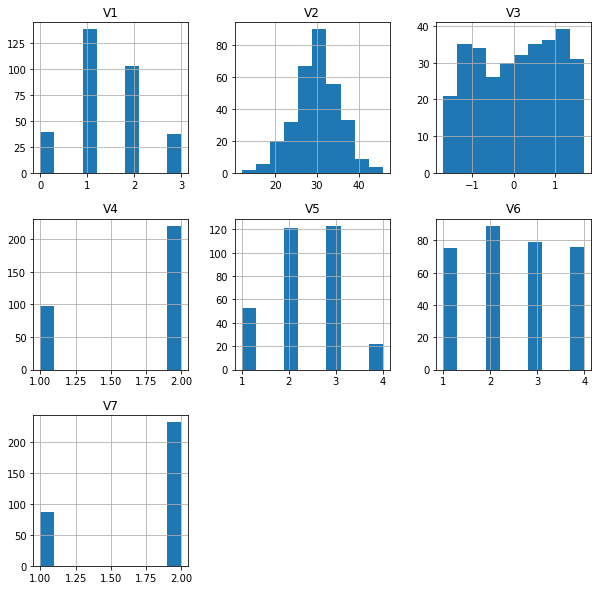

In [173]:
train_data[(train_data['Promotion']=='No') & (train_data['purchase']==1)][features].hist(figsize=(10,10));


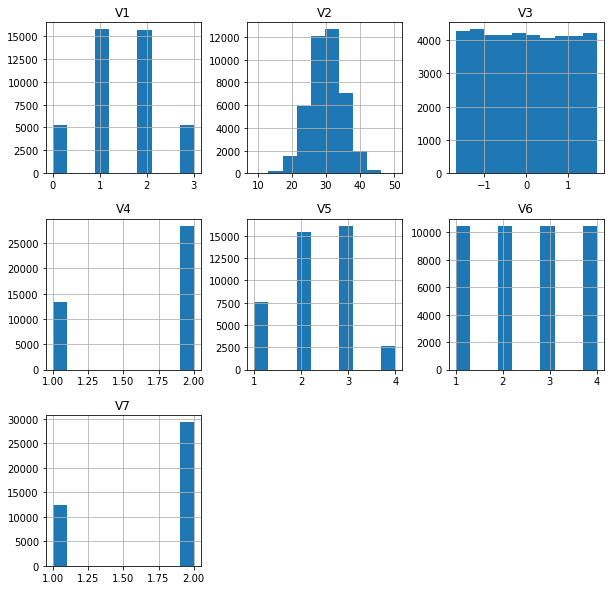

In [174]:
train_data[(train_data['Promotion']=='No') & (train_data['purchase']==0)][features].hist(figsize=(10,10));


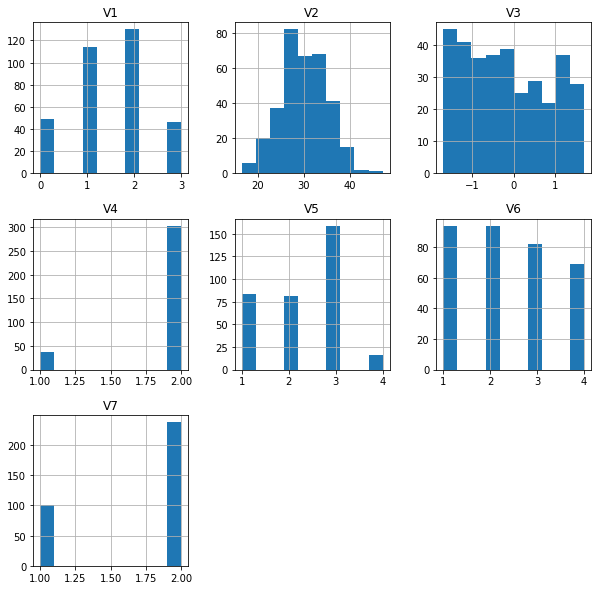

In [175]:
test_data[(test_data['Promotion']=='Yes') & (test_data['purchase']==1)][features].hist(figsize=(10,10));


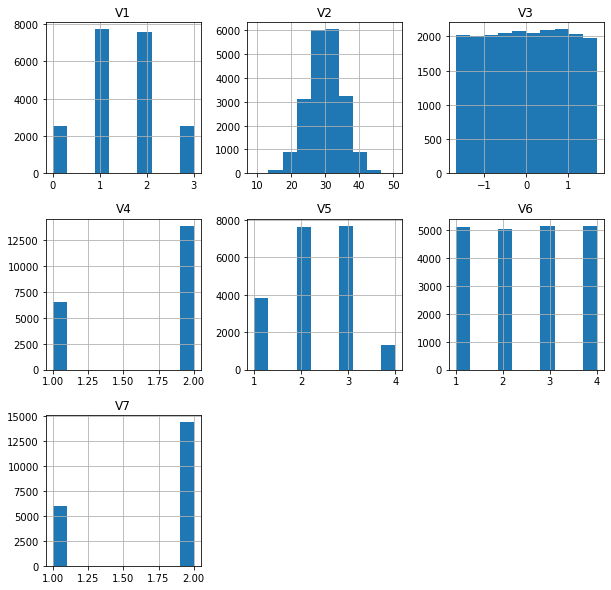

In [176]:
test_data[(test_data['Promotion']=='Yes') & (test_data['purchase']==0)][features].hist(figsize=(10,10));


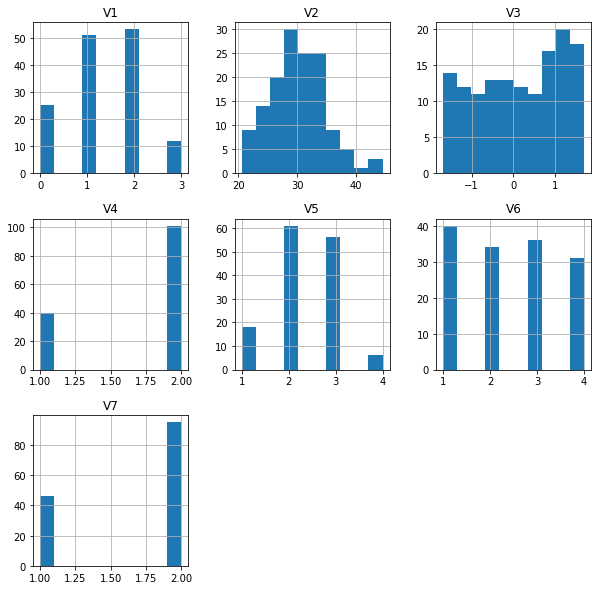

In [177]:
test_data[(test_data['Promotion']=='No') & (test_data['purchase']==1)][features].hist(figsize=(10,10));


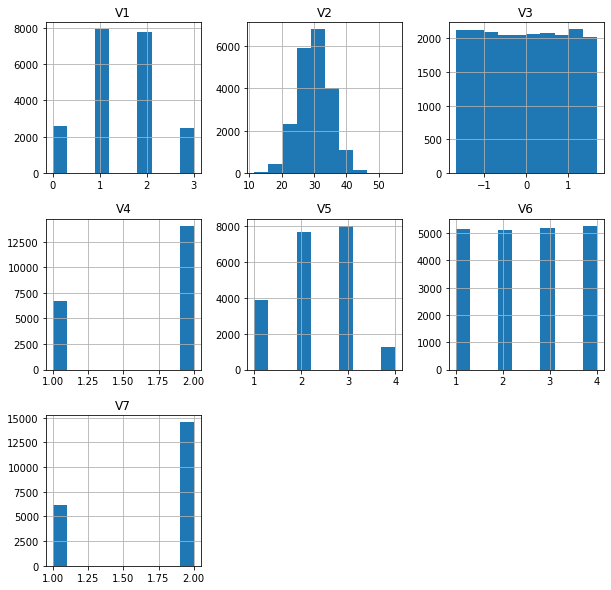

In [178]:
test_data[(test_data['Promotion']=='No') & (test_data['purchase']==0)][features].hist(figsize=(10,10));


In [179]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]            
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    promotion = []
    
    num_test_points = test.shape[0]
    
    for i in range(num_test_points):
        promotion.append('Yes')
        
    promotion = np.array(promotion)
    
    return promotion

In [182]:
test_results(promotion_strategy)


Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0096.

Your nir with this strategy is -1132.20.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.009593158278250108, -1132.1999999999998)

In [183]:
NormalIndPower().solve_power(effect_size = proportion_effectsize(.0096, .015), alpha = .05, power = 0.8,
                             alternative = 'smaller')

5089.265513625437

In [184]:
train_data[train_data['Promotion']=='Yes'].shape[0]


42364

In [185]:
train_data[train_data['Promotion']=='No'].shape[0]


42170

In [ ]:
# 1 Uplift model

In [186]:
train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./Test.csv')

In [187]:
response = []

for index, row in train_data.iterrows():
    if (row['purchase'] == 1) and (row['Promotion']=='Yes'):
        response.append(1.0)
    else:
        response.append(0.0)
        
train_data['response'] = response

In [188]:
train_data.head()


,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,response
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,0.0
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,0.0
2,4,No,0,2,30.431659,0.133583,1,1,4,2,0.0
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,0.0
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,0.0


In [189]:
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)


In [190]:
Y_train = train['response']
X_train = train[features]

Y_valid = valid['response']
X_valid = valid[features]

In [191]:
Y_train.value_counts()


0.0    67047
1.0      580
Name: response, dtype: int64

In [192]:
sm = SMOTE(random_state=42, sampling_strategy = 1.0)


X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)


In [193]:
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          max_depth = 7,\
                          min_child_weight = 5,\
                          objective = 'binary:logistic',\
                          seed = 42,\
                          gamma = 0.1,\
                          silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

[13:30:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.74629	validation_1-auc:0.56087
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.77346	validation_1-auc:0.56746
[2]	validation_0-auc:0.77602	validation_1-auc:0.56480
[3]	validation_0-auc:0.77910	validation_1-auc:0.56450
[4]	validation_0-auc:0.79753	validation_1-auc:0.55870
[5]	validation_0-auc:0.79829	validation_1-auc:0.56814
[6]	validation_0-auc:0.81814	validation_1-auc:0.57547
[7]	validation_0-auc:0.81955	validation_1-auc:0.57279
[8]	validation_0-auc:0.82778	validation_1-auc:0.57008
[

ModuleNotFoundError: No module named 'sklearn.utils._pprint'

ModuleNotFoundError: No module named 'sklearn.utils._pprint'

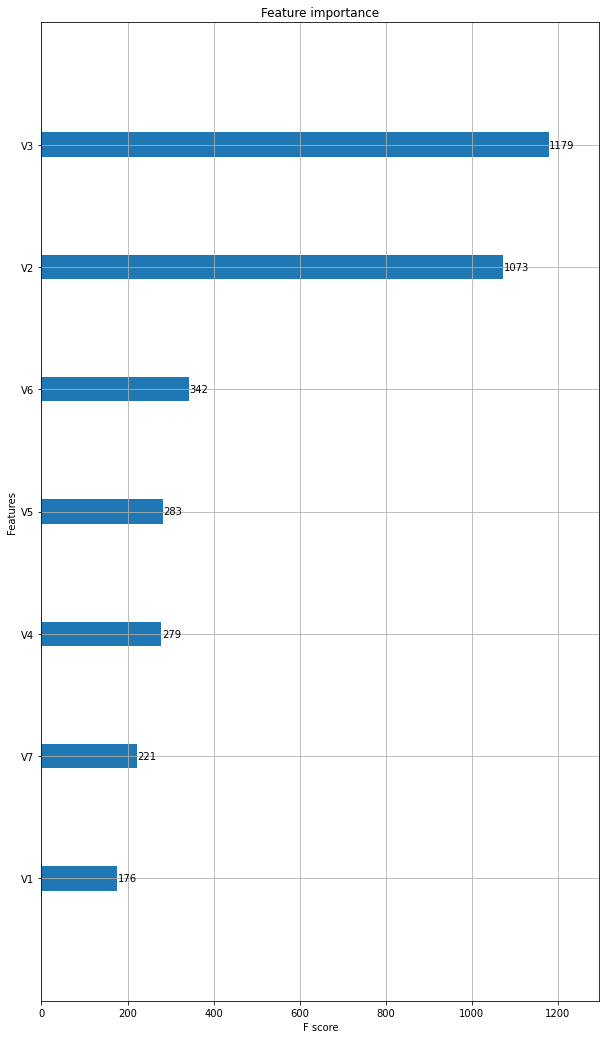

In [194]:
from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 18));
xgb.plot_importance(model, ax=ax);

In [195]:
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix
cm(Y_valid, valid_pred)

array([[12769,  3997],
       [   96,    45]])

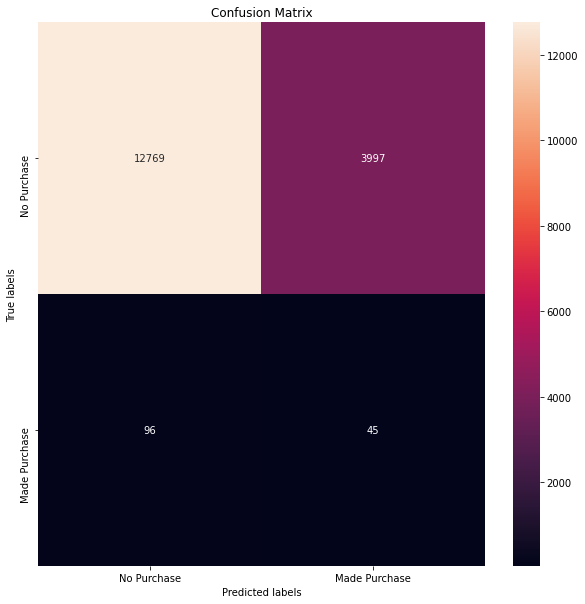

In [196]:
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [197]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    preds = model.predict(test, ntree_limit=model.best_ntree_limit)

    promotion = []
    for pred in preds:
        if pred == 1:
            promotion.append('Yes')
        else:
            promotion.append('No')
    promotion = np.array(promotion)
    return promotion

In [198]:
test_results(promotion_strategy)


Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0188.

Your nir with this strategy is 181.90.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.01880489698332953, 181.89999999999998)

In [ ]:
# 2 Two Models Approach

In [199]:
train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./Test.csv')

In [200]:
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)


In [202]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

# Generate validation data
# one for control group, another for treatment group
valid_control = valid[valid['Promotion']=='No']
Y_valid_control = valid_control['purchase']
X_valid_control = valid_control[features]

valid_exper = valid[valid['Promotion']=='Yes']
Y_valid_exper = valid_exper['purchase']
X_valid_exper = valid_exper[features]

In [203]:
train_control = train[train['Promotion']=='No']
Y_train_control = train_control['purchase']
X_train_control = train_control[features]

train_exper = train[train['Promotion']=='Yes']
Y_train_exper = train_exper['purchase']
X_train_exper = train_exper[features]

In [205]:
sm = SMOTE(random_state=42, sampling_strategy = 1.0)

X_train_control_upsamp, Y_train_control_upsamp = sm.fit_sample(X_train_control, Y_train_control)
X_train_control_upsamp = pd.DataFrame(X_train_control_upsamp, columns=features)
Y_train_control_upsamp = pd.Series(Y_train_control_upsamp)

X_train_exper_upsamp, Y_train_exper_upsamp = sm.fit_sample(X_train_exper, Y_train_exper)    
X_train_exper_upsamp = pd.DataFrame(X_train_exper_upsamp, columns=features)
Y_train_exper_upsamp = pd.Series(Y_train_exper_upsamp)

In [206]:
eval_set = [(X_train_control_upsamp, Y_train_control_upsamp), (X_valid_control, Y_valid_control)]
model_control = xgb.XGBClassifier(learning_rate = 0.1,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'binary:logistic',\
                                  seed = 42,\
                                  gamma = 1,\
                                  #colsample_bytree = 0.1,\
                                  silent = True)
model_control.fit(X_train_control_upsamp, Y_train_control_upsamp, eval_set=eval_set,\
                    eval_metric="auc", verbose=True, early_stopping_rounds=30)

[18:19:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.74952	validation_1-auc:0.47418
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.77279	validation_1-auc:0.47491
[2]	validation_0-auc:0.77790	validation_1-auc:0.46787
[3]	validation_0-auc:0.79046	validation_1-auc:0.46339
[4]	validation_0-auc:0.79597	validation_1-auc:0.47260
[5]	validation_0-auc:0.81432	validation_1-auc:0.47854
[6]	validation_0-auc:0.82451	validation_1-auc:0.48179
[7]	validation_0-auc:0.85821	validation_1-auc:0.49811
[8]	validation_0-auc:0.86333	validation_1-auc:0.50436
[

ModuleNotFoundError: No module named 'sklearn.utils._pprint'

ModuleNotFoundError: No module named 'sklearn.utils._pprint'

In [207]:
eval_set = [(X_train_exper_upsamp, Y_train_exper_upsamp), (X_valid_exper, Y_valid_exper)]
model_exper = xgb.XGBClassifier(learning_rate = 0.1,\
                                max_depth = 7,\
                                min_child_weight = 5,\
                                objective = 'binary:logistic',\
                                seed = 42,\
                                gamma = 1,\
                                #colsample_bytree = 0.1,\
                                silent = True)
model_exper.fit(X_train_exper_upsamp, Y_train_exper_upsamp, eval_set=eval_set,\
                eval_metric="auc", verbose=True, early_stopping_rounds=30)

[18:19:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.74798	validation_1-auc:0.57693
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.77218	validation_1-auc:0.58092
[2]	validation_0-auc:0.77509	validation_1-auc:0.57875
[3]	validation_0-auc:0.78000	validation_1-auc:0.57774
[4]	validation_0-auc:0.79922	validation_1-auc:0.58299
[5]	validation_0-auc:0.82326	validation_1-auc:0.58413
[6]	validation_0-auc:0.82271	validation_1-auc:0.58367
[7]	validation_0-auc:0.82336	validation_1-auc:0.58206
[8]	validation_0-auc:0.83030	validation_1-auc:0.58305
[

ModuleNotFoundError: No module named 'sklearn.utils._pprint'

ModuleNotFoundError: No module named 'sklearn.utils._pprint'

In [208]:
control_valid_pred = model_control.predict(X_valid_control, ntree_limit=model_control.best_ntree_limit)
exper_valid_pred = model_exper.predict(X_valid_exper, ntree_limit=model_exper.best_ntree_limit)

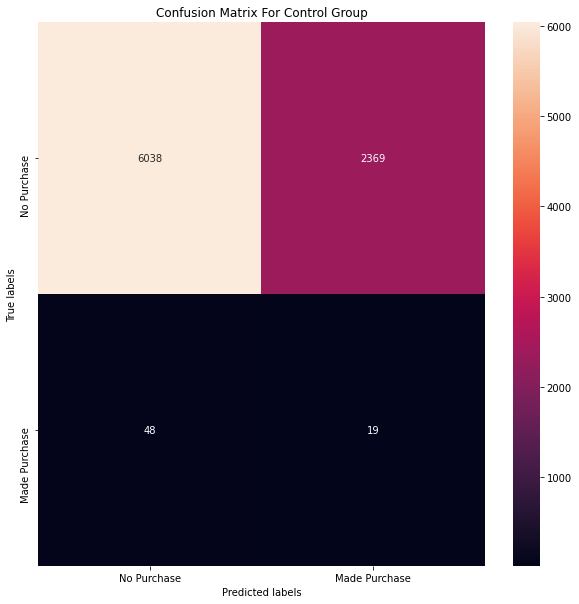

In [209]:
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid_control, control_valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix For Control Group'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

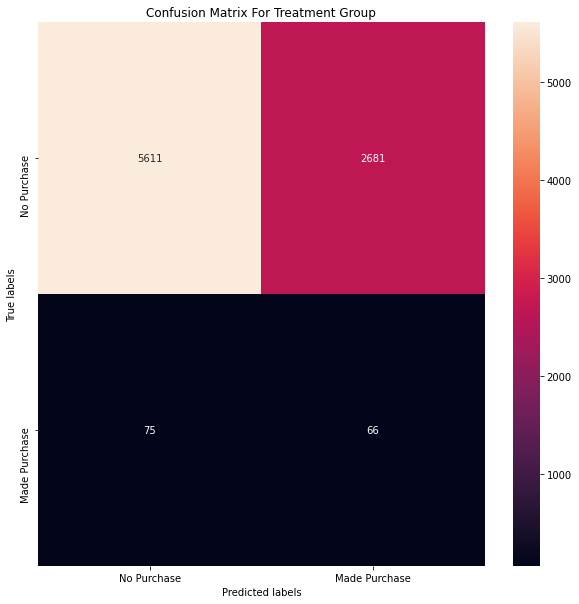

In [210]:
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid_exper, exper_valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix For Treatment Group'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [211]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]            
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    pred_probs_contol = model_control.predict_proba(test, ntree_limit=model_control.best_ntree_limit)

    pred_probs_exper = model_exper.predict_proba(test, ntree_limit=model_exper.best_ntree_limit)

    # get difference in probabilities between experimental and cpntrol model for purchase = 1 label
    lift = pred_probs_exper[:,1] - pred_probs_contol[:,1]
    
    promotion = []
    
    # Only send promotions to top 3 percentile of probabilities
    cutoff_lift = np.percentile(lift, 97)
    
    for prob in lift:
        if prob > 0:
            if prob > cutoff_lift:
                promotion.append('Yes')
        else:
            promotion.append('No')

    promotion = np.array(promotion)
    
    return promotion

In [213]:
test_results(promotion_strategy)


Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is -0.0015.

Your nir with this strategy is -103.15.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(-0.0015026103367283099, -103.14999999999999)

In [ ]:
# 3 Single Model with Treatment Indicator Variable

In [214]:
train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./Test.csv')

In [215]:
train_data['treatment'] = np.where(train_data['Promotion'] == "Yes", 1, 0)
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,treatment
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,0
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,0
2,4,No,0,2,30.431659,0.133583,1,1,4,2,0
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,0
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,1


In [216]:
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'treatment']

Y_train = train['purchase']
X_train = train[features]

Y_valid = valid['purchase']
X_valid = valid[features]

In [218]:
sm = SMOTE(random_state=42, sampling_strategy = 1.0)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)

In [219]:
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'binary:logistic',\
                                  seed = 42,\
                                  gamma = 0.1,\
                                  silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="auc", verbose=True, early_stopping_rounds=30)

[09:47:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.73251	validation_1-auc:0.57426
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.74280	validation_1-auc:0.58503
[2]	validation_0-auc:0.76424	validation_1-auc:0.57069
[3]	validation_0-auc:0.77747	validation_1-auc:0.56606
[4]	validation_0-auc:0.77953	validation_1-auc:0.56874
[5]	validation_0-auc:0.78945	validation_1-auc:0.56157
[6]	validation_0-auc:0.79897	validation_1-auc:0.56776
[7]	validation_0-auc:0.80738	validation_1-auc:0.56621
[8]	validation_0-auc:0.80653	validation_1-auc:0.56803
[

ModuleNotFoundError: No module named 'sklearn.utils._pprint'

ModuleNotFoundError: No module named 'sklearn.utils._pprint'

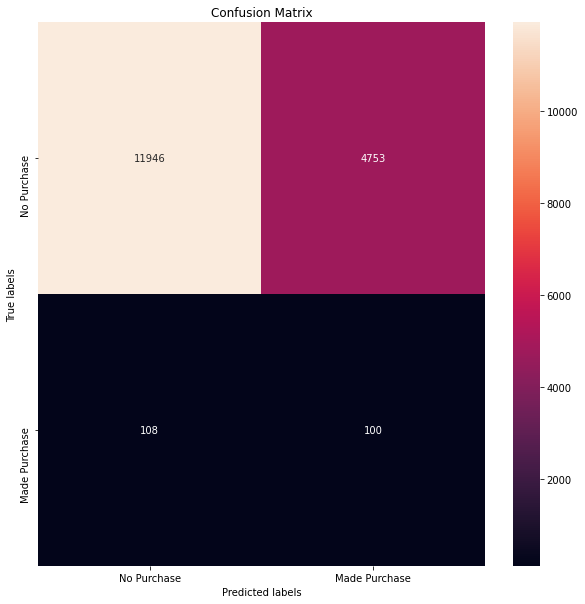

In [220]:
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [221]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    # Fit a model with treatment = 1 for all data points
    test['treatment'] = 1.0
    preds_treat = model.predict_proba(test, ntree_limit=model.best_ntree_limit)
    
    # Fit a model with treatment = 0 for all data points
    test['treatment'] = 0.0
    preds_cont = model.predict_proba(test, ntree_limit=model.best_ntree_limit)
    
    lift = preds_treat[:,1] - preds_cont[:,1]
    
    promotion = []
    
    for prob in lift:
        if prob > 0:
            promotion.append('Yes')
        else:
            promotion.append('No')

    promotion = np.array(promotion)
    
    return promotion

In [222]:
test_results(promotion_strategy)


Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0153.

Your nir with this strategy is 17.35.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


/Users/tdulman/opt/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/tdulman/opt/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(0.015281329833784225, 17.350000000000136)

In [223]:
# 4 Four Quadrant 

In [224]:
train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./Test.csv')

In [225]:
target = []
for index, row in train_data.iterrows():
    if (row['Promotion'] == "Yes") & (row['purchase'] == 1):
        # TR group
        target.append(0)
    elif (row['Promotion'] == "No") & (row['purchase'] == 1):
        # CR group
        target.append(1)
    elif (row['Promotion'] == "Yes") & (row['purchase'] == 0):
        # TN group
        target.append(2)
    else: #CN group
        target.append(3)

train_data['target'] = target
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,target
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,3
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,3
2,4,No,0,2,30.431659,0.133583,1,1,4,2,3
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,3
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,2


In [226]:
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

Y_train = train['target']
X_train = train[features]

Y_valid = valid['target']
X_valid = valid[features]

In [227]:
Y_train.value_counts()


3    33444
2    33351
0      580
1      252
Name: target, dtype: int64

In [228]:
sm = SMOTE({0:33444, 1:33444, 2:33444, 3:33444}, random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)
Y_train_upsamp.value_counts()

/Users/tdulman/opt/anaconda3/envs/myenv/lib/python3.6/site-packages/imblearn/utils/_validation.py:638: FutureWarning: Pass sampling_strategy={0: 33444, 1: 33444, 2: 33444, 3: 33444} as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


3    33444
2    33444
1    33444
0    33444
Name: target, dtype: int64

In [229]:
X_train_upsamp.head()


,V1,V2,V3,V4,V5,V6,V7
0,3,34.470493,-1.078506,1,1,1,2
1,1,28.065819,-1.165083,1,1,3,1
2,1,27.142590,-1.511395,1,3,3,2
3,3,28.782344,-1.078506,1,1,1,2
4,2,39.605508,-0.645617,2,3,1,2


In [230]:
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          num_class=4,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'multi:softmax',\
                                  seed = 42,\
                                  gamma = 0.1,\
                                  silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="mlogloss", verbose=True, early_stopping_rounds=30)

[09:53:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.36249	validation_1-mlogloss:1.37688
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.34081	validation_1-mlogloss:1.36854
[2]	validation_0-mlogloss:1.32201	validation_1-mlogloss:1.36116
[3]	validation_0-mlogloss:1.30453	validation_1-mlogloss:1.35433
[4]	validation_0-mlogloss:1.28843	validation_1-mlogloss:1.34784
[5]	validation_0-mlogloss:1.27327	validation_1-mlogloss:1.34212
[6]	validation_0-mlogloss:1.25947	validation_1-mlogloss:1.33666
[7]	validation_0-mlogloss:1.2

ModuleNotFoundError: No module named 'sklearn.utils._pprint'

ModuleNotFoundError: No module named 'sklearn.utils._pprint'

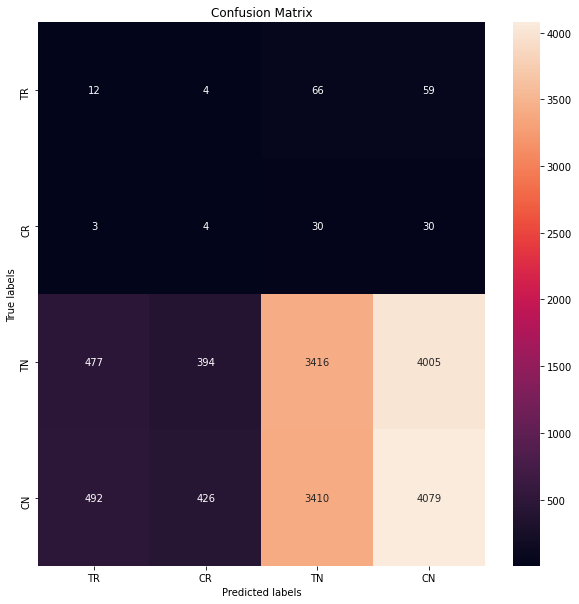

In [231]:
# TR: treatment and respond group (received promotion and made purchase)
# CR: control and respond group (did not receive promotion but made purchase)
# TN: treatment and no respond group (received promotion but did not made purchase)
# CR: control and no respond group (did not receive promotion and made no purchase)
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']); 
ax.yaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']);

In [232]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    pred = model.predict(test, ntree_limit=model.best_ntree_limit)
    
    promotion = []
    
    for pred in pred:
        if pred == 0:
            promotion.append('Yes')
        else:
            promotion.append('No')
    
    promotion = np.array(promotion)
    
    return promotion

In [233]:
test_results(promotion_strategy)


Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0184.

Your nir with this strategy is 42.80.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.018378341516639387, 42.80000000000001)